<a href="https://colab.research.google.com/github/ramonVDAKKER/tutorial-AB-testing/blob/main/AB_testing_explained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inside the black box of A/B testing

A/B testing basically compares two versions of an object in order to determine which one is best. The standard example is to develop two versions of a webpage and to direct part of the users to site A and another part to site B. In that setting, a typical goal is to determine which option yields the best conversion.

This notebook **aims to explain the statistical aspects of A/B testing**. The **distribution** of the test statistic under the **null** as well as under the **alternative hypothesis** will be discussed. As such, the **power** of the test is determined. Moreover, given specification of a test, including the required power, we will determine **how much observations are needed** to conduct a A/B test that meets the requirements. This will **explain the mechanics underlying the black box A/B sample size calculators**. Throughout, we will use **Monte Carlo simulations to illustrate the theoretical results**.

*Prerequisites*: familiarity with basic probability theory and statistics inculding the Central Limit Theorem and hypothesis testing.

## 1.1 Setup and notation

Assume that there are two populations: population A and population B. From population A we receive a sample $X_1,\dots,X_{n_A}$ of independent and identically distributed (i.i.d.) binary observations $X_1,\dots,X_{n_A}$. We denote $p_A = \mathbb{P}(X_i=1)=1-\mathbb{P}(X_i=0)$.
Similary, we assume that we receive i.i.d. observations $Y_1,\dots,Y_{n_B}$ from population B and denote $p_B = \mathbb{P}(Y_i=1)$. Moreover, it is assumed that the '$X$-sample' is independent of the '$Y$-sample'.

We are interested in testing the null hypothesis $\mathrm{H}_0:\, p_A=p_B$ versus the alternative $\mathrm{H}_a:\, p_B > p_A$. Thinking of $p_A$ and $p_B$ as conversion rates for two competing features on, for example, a website, we thus want to test if option B is the better one.

As usual, the idea behind constructing a test is to find an object that is 'close to 0' if the null hypothesis is true, and which deviates from 0 in case the alternative is true. So, for the above setup, it is natural to base a test statistic upon $\hat{p}_B - \hat{p}_A$. Next, one often standardizes the statistics in order to obtain a $N(0,1)$ distribution, by approximation, under the null hypothesis. This leads to the test statistic:
$$t = \frac{\hat{p}_B - \hat{p}_A}{\sqrt{  \hat{p}_B(1-\hat{p}_B) /n_B + \hat{p}_A(1-\hat{p}_A)/n_A}},$$
where $\hat{p}_A = \bar{X}_{n_A} = n^{-1} \sum_{i=1}^{n_A} X_i$, i.e. the fraction of $X$-observations with $X_i=1$, and with $\hat{p}_B$ defined in a similar fashion. Please note that this is actually the two-sample t-test (with unequal variances) tailored for binary observations. 

The central limit theorem (and calculus rules for convergence in distribution) (indeed) imply that we have,
for large values of $n_A$ and $n_B$ and under the null hypothesis $H_0$, $t\stackrel{d}{\approx} N(0,1)$. This leads to rejecting $H_0$ if and only if $t> \Phi^{-1}(1-\alpha)$, where $\alpha$ denotes the significance level. For $\alpha=5\%$ we have $\Phi^{-1}(1-\alpha)\approx 1.65$.

# 1.2. Imports

In [ ]:
import numpy as np
from scipy.stats import bernoulli, norm, binom
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
from ipywidgets import widgets, fixed

## 1.3 Implementation of the test statistic


Specify the significance level $\alpha$ and the number of replications to be used in the Monte Carlo experiments (more is better, but slower).

In [ ]:
alpha = 0.05  # significance level
num_replications = 25000  # no. of Monte Carlo replications to be used

The following function implements the test statistic where we also allow for the boundary case in which $\hat{p}_A(1-\hat{p}_A)=
\hat{p}_B(1-\hat{p}_B)=0$.

In [ ]:
def t_test(num_heads_A: int, n_A: int, num_heads_B: int, n_B: int, alpha:
           float = .05) -> (float, bool):
    """"On basis of the number of heads in X_1,...,X_{n_A} and Y_1,...,Y_{n_B}
    and the significance level alpa, this function determines the realization
    of the t-test (t) and the outcome (phi) of the test."""
    hat_p_A = num_heads_A / n_A
    hat_p_B = num_heads_B / n_B
    if max(hat_p_A, hat_p_B) < 1 and min(hat_p_A, hat_p_B) > 0:
        t = (hat_p_B - hat_p_A) / np.sqrt(hat_p_A * (1 - hat_p_A) / n_A
                                          + hat_p_B * (1 - hat_p_B) / n_B)
    elif ((hat_p_A == 0) and (hat_p_B == 0)) or ((hat_p_A == 1) and
                                                 (hat_p_B == 1)):
        t = 0
    elif hat_p_B == 1 and hat_p_A == 0:
        t = np.inf
    elif hat_p_A == 1 and hat_p_B == 0:
        t = - np.inf
    else:
        t = 0
    phi = (t >= norm.ppf(1 - alpha))
    return t, phi

Example:


In [ ]:
t_test(10, 50, 30, 40, alpha)

(6.192884828895332, True)

The following function can be used to simulate datasets and the corresponding realizations of the test statistics. This will be used for the Monte Carlo illustrations.

In [ ]:
def simulate_distribution(p_A: float, n_A: int, p_B: float, n_B: int, alpha:
                          float, num_replications: int):
    """This function simulaties \sum_{i=1}^{n_A} X_i and \sum_{i=1}^{n_B} Y_i
    using i.i.d. draws from a Bernoulli(p_A) and Bernoulli(p_B) distribution
    respectively and calculates the outcome of the test. This process is
    repeated num_replications times and alpha is used as significance level."""
    no_heads_A = binom.rvs(n_A, p_A, loc=0, size=num_replications)
    no_heads_B = binom.rvs(n_B, p_B, loc=0, size=num_replications)
    vectorized_t_test = np.vectorize(t_test)
    t, phi = vectorized_t_test(no_heads_A, n_A, no_heads_B, n_B, alpha)
    return t, phi

Example:

In [ ]:
simulate_distribution(.2, 50, .3, 40, alpha, 10)

(array([ 2.32553072,  1.92453605, -1.08857252,  0.59951513,  1.36131252,
        -2.27103349,  1.31290387, -0.38287301,  2.32521247,  2.32521247]),
 array([ True,  True, False, False, False, False, False, False,  True,
         True]))

## 1.4 Distribution of the test statistic under the null hypothesis

As indicated in Section 1.1, the test statistic $t$ is approximately $N(0,1)$ distributed for large $n_A$ and large $n_B$. Our choice for the critical value, i.e. $\Phi^{-1}(1-\alpha)$ is based upon this approximation.

In this section we will assess the quality of the approximation. To this end, we introduce the following function that performs a Monte Carlo experiment.

*Remark*: as we are dealing with binary data, we could also derive the exact distribitution. We do not pursue this over here, as we want to provide a setup that easily extends to situations in which the exact distribution is unknown and one cannot (easily) avoid relying on the approximating $N(0,1)$ distribution.

In [ ]:
def null_distribution(n_A: int, n_B: int, p_A: float, alpha: float,
                      num_replications: int):
    """This function determines an approximation to the exact finite-sample
    distribution by means of Monte Carlo simulations and provides a comparison
    to the limiting N(0,1) distribution."""
    p_B = p_A  # as they are equal under the null hypothesis
    t, phi = simulate_distribution(p_A, n_A, p_B, n_B, alpha, num_replications)
    fig, ax = plt.subplots(1, 1)
    ax.set_title(f"Distribution of $t$, on basis of {num_replications:,} "
                 + f"Monte Carlo replications,\n n_A={n_A}, n_B={n_B} and "
                 + f"$p_A=p_B=${p_A:.2f} "
                 + "versus the N(0, 1) distribution.")
    ax.set_ylim([0, .6])
    ax.set_xlim([-4, 4])
    x = np.linspace(-4, 4, 100)
    y = stats.norm.pdf(x)
    ax.plot(x, y, "r", lw=2)
    sns.set_theme()
    sns.histplot(t, stat="density")
    print(f"The rejection probability is {np.mean(phi):.2f}. If the "
          + "approximation\nby the N(0,1) would be perfect and we would have no"
          + " noise\ndue to using Monte Carlo to approximate the finite-sample"
          + f"\ndistribution this probability would be equal to {alpha}.")

The following widget can be used to analyze the impact of the sample sizes $n_A$ and $n_B$ and the probabilities $p_A=p_B$ on the quality of the approximation by the standard normal distribution.



In [ ]:
 config_num_obs = [50, 100, 1000, 10000]
 config_null_prob = np.linspace(0.1, 0.9, 9)
 widgets.interact(null_distribution, n_A=config_num_obs, n_B=config_num_obs,
                  p_A=config_null_prob, alpha=fixed(alpha),
                  num_replications=fixed(num_replications))

interactive(children=(Dropdown(description='n_A', options=(50, 100, 1000, 10000), value=50), Dropdown(descript…

<function __main__.null_distribution>

## 2. Distribution under the alternative and power of the test

Recall that the power of a test is defined as the probability that it rejects the null hypothesis.
So under the null hypothesis the power should be close to $\alpha$ (by construction, see Section 1.4) and under the alternative
hypothesis we would like to have a power that is close to 1. 

In this section we derive a formula for the power of $t$. To facilitate this discussion we assume that $n_A =\operatorname{round} (\lambda n) $ and
$n_B = n- n_A$ where $\lambda \in (0,1)$. In words: $n$ is the total number of observations we can collect
and $\lambda$ is the fraction of observations that comes from population A.

In the previous section we already derived the distribution of $t$ under the null hypothesis. Now we focus on the distribution under the alternative hypothesis.
If $p_B > p_A$, the Central Limit Theorem (though a non-standard one) and related calculus rules imply that, for large 
$n$,
\begin{align*}
t &= 
 \frac{\hat{p}_B - p_B  - (\hat{p}_A - p_A)}{\sqrt{  \hat{p}_B(1-\hat{p}_B) /n_B + \hat{p}_A(1-\hat{p}_A)/n_A}}
+ \frac{p_B - p_A  }{\sqrt{  \hat{p}_B(1-\hat{p}_B) /n_B + \hat{p}_A(1-\hat{p}_A)/n_A}} \\
&\stackrel{d}{\approx} 
N(0, 1) + 
\frac{p_B - p_A  }{\sqrt{ \frac{  p_B(1-p_B) }{ (1-\lambda) n}  + \frac{ p_A(1-p_A)}{  \lambda n}}}.
\end{align*}
Observe that under the alternative hypothesis, i.e. $p_B>p_A$, the second term in the previous display yields a shift to the right which leads to a higher rejection probability. Moreover, if $n$ increases
this term tends to $\infty$ which would mean that the test would (indeed) make the correct decision.
These observations can also be seen from the power function:

$$
\text{power}=\mathbb{P}(\text{reject } H_0) 
= \mathbb{P} (  t > \Phi^{-1}(1-\alpha) )  
\approx 
1 - \Phi\left(
\Phi^{-1}(1-\alpha) - 
\frac{p_B - p_A  }{\sqrt{ \frac{  p_B(1-p_B) }{ (1-\lambda) n}  + \frac{ p_A(1-p_A)}{  \lambda n}}}
\right).
$$

The following widget can be used to illustrate how the distribitution of $t$ and the approximation by the shifted normal distribution look like under the alternative. Moreover, the power (on basis of Monte Carlo replications as well as on basis of the normal approximation) is computed.

In [ ]:
def MC_power(n: int, fraction_A: float, p_A: float, p_B: float, alpha: float,
             num_replications: int):
    """"This functions illustrates the power, using Monte Carlo simulations,
    and presents the distribution of the test statistic as well as its
    asymptotic approximation."""
    n_A = np.int(fraction_A * n)
    n_B = n - n_A
    t, phi = simulate_distribution(p_A, n_A, p_B, n_B, alpha, num_replications)
    fig, ax = plt.subplots(1, 1)
    ax.set_title(f"Distribution of $t$, on basis of {num_replications:,} "
                 + f"Monte Carlo replications, p_A={p_A:.2f},\n p_B={p_B:.2f},"
                 + f" n={n}, and lambda={fraction_A}, its normal approximation "
                 + "(blue)\nand the (approximating) distribution under the "
                 + "null (in red).")
    ax.set_ylim([0, .6])
    x = np.linspace(-4, 8, 100)
    y = stats.norm.pdf(x)
    ax.plot(x, y, "r", lw=2)  # approximating distribution under null
    sns.histplot(t, stat="density")
    h = np.sqrt(n) * (p_B - p_A)  # parameter for local asymptotics
    mean_local_alternative = h / np.sqrt(p_A * (1 - p_A) / fraction_A
                                         + p_B * (1 - p_B) / (1 - fraction_A))
    x = np.linspace(-4, 4 + mean_local_alternative, 100)
    y = stats.norm.pdf(x, loc=mean_local_alternative, scale=1)
    ax.plot(x, y, "b", lw=2)
    plt.fill_between(x[x > norm.ppf(1 - alpha)],
                     norm.pdf(x[x > norm.ppf(1 - alpha)],
                              loc=mean_local_alternative))
    p = 1 - norm.cdf(norm.ppf(1 - alpha), loc=mean_local_alternative, scale=1)


def MC_power_aux(n: int, fraction_A, p_A, p_B):
    return MC_power(n, fraction_A, p_A, p_B, alpha, num_replications)

In [ ]:
config_num_obs = [200, 1000, 2000, 20000]
config_lambda = np.linspace(.1, .9, 5)
config_prob = np.linspace(0.1, 0.9, 9)
widgets.interact(MC_power_aux, n=config_num_obs, fraction_A=config_lambda,
                 p_A=config_prob, p_B=config_prob)

interactive(children=(Dropdown(description='n', options=(200, 1000, 2000, 20000), value=200), Dropdown(descrip…

<function __main__.MC_power_aux>

In case you are only interested in the power you can use the following functions.

In [ ]:
def power_on_basis_of_MC(n: int, fraction_A: float, p_A: float, p_B: float,
                         alpha: float, num_replications: int):
    "This functions calculates the power, using Monte Carlo simulations"
    n_A = np.int(fraction_A * n)
    n_B = n - n_A
    _, phi = simulate_distribution(p_A, n_A, p_B, n_B, alpha, num_replications)
    return np.mean(phi)


def power_on_basis_of_aa(n: int, fraction_A: float, p_A: float, p_B: float,
                         alpha: float):
    "This functions calculates the power, using the asymptotic approximation"
    n_A = np.int(fraction_A * n)
    n_B = n - n_A
    h = np.sqrt(n) * (p_B - p_A)  # parameter for local asymptotics
    mean_local_alternative = h / np.sqrt(p_A * (1 - p_A) / fraction_A
                                         + p_B * (1 - p_B) / (1 - fraction_A))
    p = 1 - norm.cdf(norm.ppf(1 - alpha), loc=mean_local_alternative, scale=1)
    return p

Example:

In [ ]:
n = 1000
fraction_A = .5
p_A = .2
p_B = .23
p = power_on_basis_of_MC(n, fraction_A, p_A, p_B, alpha, num_replications)
print(f"The power on basis of MC simulations is {p:.3f}.")
p = power_on_basis_of_aa(n, fraction_A, p_A, p_B, alpha)
print(f"The power on basis of asymptotic approximation is {p:.3f}.")

The power on basis of MC simulations is 0.314.
The power on basis of asymptotic approximation is 0.312.


## 3. Determine the required sample size

When you set up an A/B test yourself, you obviously would like to know how large $n$ should be in order to make an informed decision. In this section we derive a formula for $n$.

To this end you need to specify (perceived) values for $p_A$ and $p_B$. For example, $p_A=20\%$ and $p_B=23\%$.
If A represents the current situation then you typically indeed have an idea about $p_A$. The value for $p_B$ that you would like to detect could, for example, come from a business case: B would be favorable to A if B has a conversion rate that is 3\%-points higher.
Moreover, you need to specify with what power you want to detect the alternative hypothesis in case it is true. If you would set this power equal to 80\%, then the probability of not rejecting $H_0$ while in fact $p_B>p_A$ would be equal to 20%.

Denoting the desired power by $\theta$ we obtain 
$$
\Phi^{-1}(1- \theta) = \Phi^{-1}(1-\alpha) 
- 
\frac{p_B - p_A  }{\sqrt{ \frac{  p_B(1-p_B) }{ (1-\lambda)n }  + \frac{ p_A(1-p_A)}{  \lambda n }}},
$$
which yields
$$
n = \operatorname{ceil}\left[
\frac{\left(
\Phi^{-1}(1-\alpha) - 
\Phi^{-1}(1-\theta)\right)^2}{(p_B - p_A)^2}  
\left( \frac{  p_B(1-p_B) }{ (1-\lambda) }  + \frac{ p_A(1-p_A)}{  \lambda }\right)
\right].
$$

As an illustration we will apply 
this formula for the case $p_A=20\%$, $p_B=23\%$, $\lambda=.5$, $\alpha=.05$, and
$\theta=.8$, yielding $n=4632$. 

In [ ]:
def required_total_sample_size(fraction_A: float, p_A: float, p_B: float,
                               desired_power: float, alpha:
                               float = .05) -> int:
    """"This functions determines the sample size n that one needs to achieve
    desired_power as power. Note that p_B > p_A is required."""
    term_1 = norm.ppf(1 - alpha) - norm.ppf(1 - desired_power)
    term_2 = np.sqrt(p_A * (1 - p_A) / fraction_A
                     + p_B * (1 - p_B) / (1 - fraction_A)) / (p_B - p_A)
    n = int(np.ceil(math.pow(term_1 * term_2, 2)))
    print(f"Consider a one-sided level alpha={alpha} test with "
          + f"{100*fraction_A}% of the total no. of observations\nbelonging to "
          + f"group A. Then we need {n} observations to detect alternative "
          + f"p_B={p_B}\nagainst null p_A=p_B, with p_A={p_A}, with "
          + f"power={desired_power}.")
    return n

In [ ]:
# Example:
fraction_A = .5
p_A = .2
p_B = .23
power_detecting_min_p_B = .80  # required powe to detect alternative p_B
alpha = .05  # asymptotic size of test
n_req = required_total_sample_size(fraction_A, p_A, p_B,
                                   power_detecting_min_p_B, alpha)

Consider a one-sided level alpha=0.05 test with 50.0% of the total no. of observations
belonging to group A. Then we need 4632 observations to detect alternative p_B=0.23
against null p_A=p_B, with p_A=0.2, with power=0.8.


To corroborate this result we generate 100,000 Monte Carlo replications, using the specified parameters. On basis of the 100,000 realization of the test, we indeed observe approximately 80\% as power.

The power on basis of MC simulations is 0.799.


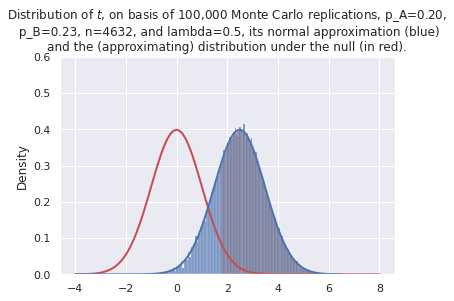

In [ ]:
p = power_on_basis_of_MC(n_req, fraction_A, p_A, p_B, alpha, 100000)
print(f"The power on basis of MC simulations is {p:.3f}.")
MC_power(n_req, fraction_A, p_A, p_B, alpha, 100000)

## 4. Concluding remarks

* Please note that the formulas for the power and $n$ can also be used to determine the optimal choice for $\lambda$ (relative to choices for $p_A$ and $p_B$).
* As we have been discussing binary observations we could have used the binomial distribution in order to arrive at exact results. Our approach can, however, also be used for non-binary data. In that case you would obviously need to adapt the denominator of $t$ and the formulas for the power and $n$; these changes should be clear from our exposition. 
* Although the null distribution $t\stackrel{d}{\approx} N(0,1)$ can indeed be fully understood from `basic' statistical theory, the distribution under the alternative is more subtle. Here we need to use 'local asymptotics'. We refer the interested reader to Lehmann (1997) for the necessary tools.  